In [30]:
import astropy
import numpy as np
import matplotlib.pyplot as plt
from sherpa.astro.data import DataPHA
from sherpa.astro.io import read_pha, read_arf, read_rmf
from astropy.io import fits
import os
from sherpa.astro.plot import DataPHAPlot
import copy
from sherpa.utils.logging import SherpaVerbosity
import scipy as sci
import tensorflow as tf
import keras
import visualkeras
from decimal import Decimal

In [2]:
# Load in all of the spectra for each observation for each detector as DataPHA objects and in the 
# process assign the response files and background (and background subtract)
obs_ids = []
spectra = {}
for source_dir in os.listdir('spectra_files'):
    source_path = os.path.join('spectra_files', source_dir)
    if os.path.isdir(source_path):
        for obsid_dir in os.listdir(source_path):
            obsid_path = os.path.join(source_path, obsid_dir)
            if os.path.isdir(obsid_path):
                obsid_trimmed = f"{obsid_path.split('/')[-2]}/{obsid_path.split('/')[-1]}"
                if obsid_trimmed != 'her_x-1/01001899': # for some reason the rmf doesn't work with this one
                    print(f'Processing {obsid_trimmed}')
                    obs_ids.append(obsid_trimmed)
                    stokes = ['I', 'Q', 'U']
                    for stoke in stokes:
                        for det in range(1, 4):
                            for reg in ['src', 'bkg']:
                                spec_hdu = fits.open(f'{obsid_path}/ixpe_det{det}_{reg}_{stoke}.pha')
                                with SherpaVerbosity("ERROR"):
                                    pha = read_pha(spec_hdu)
                                if stokes == 'I':
                                    arf = read_arf(f'responses/ixpe_d{det}_20170101_alpha075_05.arf')
                                else:
                                    arf = read_arf(f'responses/ixpe_d{det}_20170101_alpha075_05.mrf')
                                rmf = read_rmf(f'responses/ixpe_d{det}_20170101_alpha075_02.rmf')
                                pha.set_response(arf, rmf)  
                                pha.set_analysis('energy') # convert from ixpe channels to energy
                                pha.notice(2, 8) # usable energy range in keV
                                # pha.subtract()
                                spectra[f'{obsid_trimmed}/det{det}_{stoke}_{reg}'] = pha

Processing swift_j1727/03006001
Processing swift_j1727/02251301
Processing swift_j1727/02250901
Processing swift_j1727/02251001
Processing swift_j1727/03005801
Processing swift_j1727/02251101
Processing swift_j1727/03005701
Processing swift_j1727/02251201
Processing cen_x-3/01250201
Processing cen_x-3/01006501
Processing gro_j1008-57/02003501
Processing gro_j1008-57/02003601
Processing gx_5-1/02002799
Processing gx_9+1/03003801
Processing gx_3+1/03004101
Processing v395_car/03001201
Processing gx_9+9/01002401
Processing cir_x-1/02002699
Processing lmc_x-1/02001901
Processing 4u_1735-44/03004001
Processing sco_x-1/02002401
Processing 4u_1820-303/02002399
Processing cyg_x-3/02001899
Processing cyg_x-3/02250301
Processing cyg_x-3/03250301
Processing cyg_x-3/02009101
Processing smc_x-1/02007001
Processing smc_x-1/02007101
Processing smc_x-1/02007201
Processing gx_340+0/03009901
Processing gx_340+0/03003301
Processing cyg_x-2/01001601
Processing cyg_x-2/01006601
Processing exo_2030+375/0225

In [29]:
def rebin(energy, flux, bins):
    rebinnedFlux = np.histogram(energy, bins, weights=flux)[0]/np.histogram(energy, bins)[0]
    rebinnedEnergy = (bins[:-1] + bins[1:])/2
    return rebinnedEnergy, rebinnedFlux

def SumDetectorsAndBin(obsid_path, stoke, bins):
    srcCounts = 0
    bkgCounts = 0
    exposures = 0
    for det in range(1, 4):
        src = spectra[f'{obsid_path}/det{det}_{stoke}_src']
        bkg = spectra[f'{obsid_path}/det{det}_{stoke}_bkg']
        exposure = fits.open(f'spectra_files/{obsid_path}/ixpe_det{det}_src_{stoke}.pha')[0].header['EXPOSURE']
        srcCounts += src.to_plot()[1] * exposure
        bkgCounts += bkg.to_plot()[1] * exposure
        exposures += exposure
        
    srcFlux = srcCounts/exposures 
    bkgFlux = bkgCounts/exposures
    binnedSrcEnergy, binnedSrcFlux = rebin(src.to_plot()[0], srcFlux, bins)
    binnedBkgEnergy, binnedBkgFlux = rebin(bkg.to_plot()[0], bkgFlux, bins)

    # Background subtract
    binnedFlux = binnedSrcFlux - binnedBkgFlux
    binnedEnergy = binnedSrcEnergy
    return binnedEnergy, binnedFlux

def MSE(y_true, y_pred):
    return print("MSE = " + '%.2E' % Decimal(str(np.round(tf.reduce_mean(tf.square(y_true - y_pred)), 5))))

In [ ]:
# Bin the intensity data for each observation
intensity_data = []
for obs in obs_ids:
    stoke = 'I'
    # energy, flux = SumDetectorsAndBin(obs, stoke, np.arange(2, 8+0.1, 0.2)) # default bins of width 0.2 keV
    energy, flux = SumDetectorsAndBin(obs, stoke, np.linspace(2, 8, 33)) # 32 bins for dimensionality convenience
    intensity_data.append(flux)
intensity_data = np.asarray(intensity_data)
# Normalize the data
i_data_norm = np.zeros(intensity_data.shape)
max_vals = []
for j in range(len(intensity_data)):
    i_data_norm[j] = intensity_data[j] / np.max(intensity_data[j])
    max_vals.append(np.max(intensity_data[j]))
# Create input data with appropriate shape for the model
input = []
for i in range(len(intensity_data) ):
    input.append([intensity_data[i]])
input = np.array(input)
input = np.swapaxes(input, 1, 2)
input.shape

(79, 32, 1)

In [76]:
# Make training data by altering the intensity data with random scaling and noise
rng = np.random.default_rng(12345)
indices = rng.permutation(i_data_norm.shape[0])
training_idx, test_idx = indices[20:], indices[:20]
training_data, test_data = i_data_norm[training_idx,:], i_data_norm[test_idx,:]
i_data_aug = training_data.tolist()
l = len(i_data_aug)
test_max_vals = []
max_vals = []
for j in range(100):
    for i in range(l):
        scale = rng.uniform(0.5, 1.5)
        noise = rng.normal(0, 0.01 * np.max(training_data[i]), len(training_data[0]))
        i_data_aug.append(scale * training_data[i] + noise)
i_data_aug = np.array(i_data_aug)
for j in range(len(i_data_aug)):
    max_vals.append(np.max(i_data_aug[j]))
    i_data_aug[j] = i_data_aug[j] / np.max(i_data_aug[j])
for k in range(indices.shape[0]):
    test_max_vals.append(np.max(intensity_data[indices[k]]))

In [8]:
# Build encoder using Keras Layers API
num_filters = 8
input = keras.Input(shape=input[0].shape)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
encoded0 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(encoded0)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
decoded0 = keras.layers.Conv1D(filters=1, kernel_size=3, activation="sigmoid", padding="same")(x)

encoder0 = keras.Model(input, encoded0)
decoder0 = keras.Model(encoded0, decoded0)
autoencoder0 = keras.Model(input, decoded0)
autoencoder0.compile(optimizer='adam', loss='mean_squared_error') # default: autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [9]:
# Visualize the model architecture
autoencoder0.summary() # print summary of model architecture

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 32, 8)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 16, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 8)           │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 16, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 32, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 32, 1)          │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 721 (2.82 KB)

 Non-trainable params: 64 (256.00 B)

In [66]:
# Train the model
autoencoder0.fit(i_data_aug, i_data_aug, epochs=50, batch_size=100, shuffle=True, validation_data=(test_data, test_data))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2485e-04 - val_loss: 2.5468e-04
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7778e-04 - val_loss: 5.7222e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9501e-04 - val_loss: 3.5802e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3958e-04 - val_loss: 4.1307e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4343e-04 - val_loss: 6.4477e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3324e-04 - val_loss: 6.4651e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9602e-04 - val_loss: 5.1603e-04
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0100e-04 - val_loss: 6.7425e-04
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2661e-04 - val_loss: 8.5337e-04
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2185e-04 - val_loss: 8.0184e-04
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0800e-04 - val_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


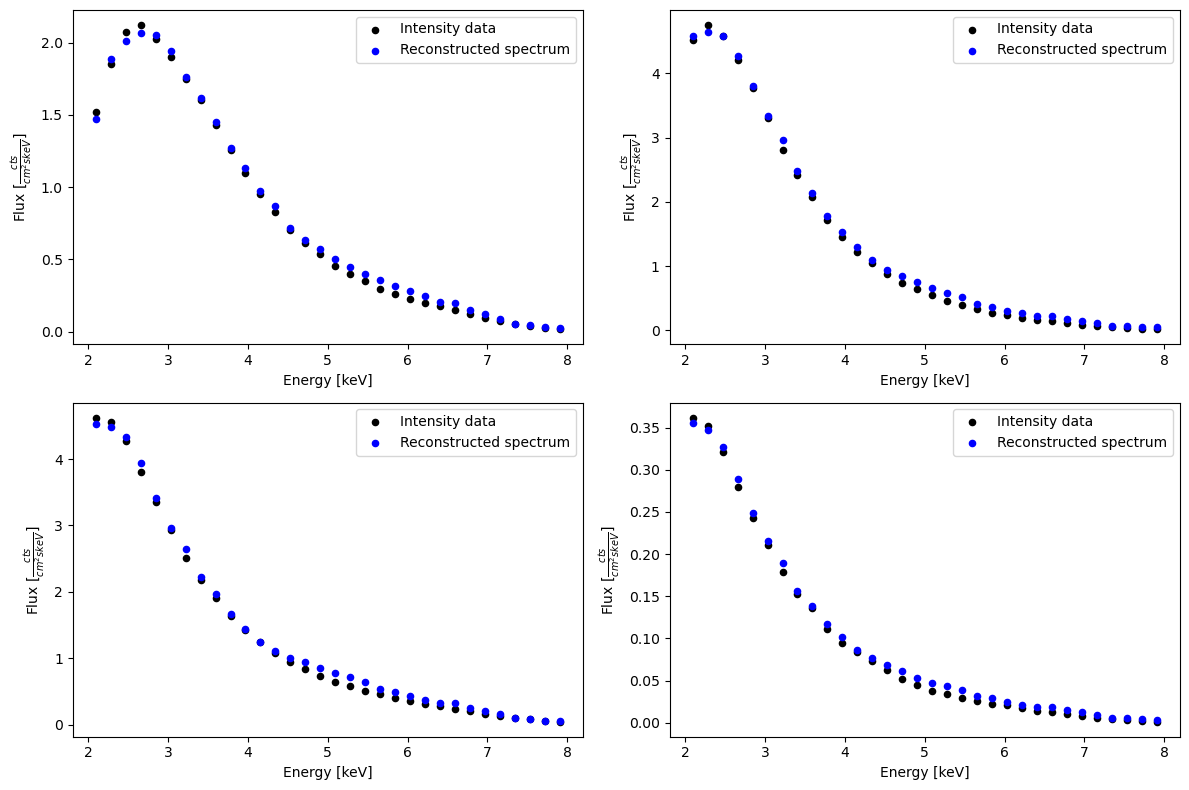

In [ ]:
predictions0 = autoencoder0.predict(test_data)
samples = [0, 4, 14, 19]
plt.figure(figsize=(12, 8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, test_max_vals[samples[i]] * test_data[samples[i]], s=20, c='black', label = 'Intensity data')
    ax.scatter(midpts, test_max_vals[samples[i]] * predictions0[samples[i]], s=20, c='blue', label = 'Reconstructed spectrum')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.tight_layout()
# plt.savefig('reconstruction_8x8.png', bbox_inches='tight', dpi=200)
plt.show()

In [69]:
# Calculate the mean squared error between the input and output
MSE(test_data, predictions0.reshape(test_data.shape))

MSE = 2.90E-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


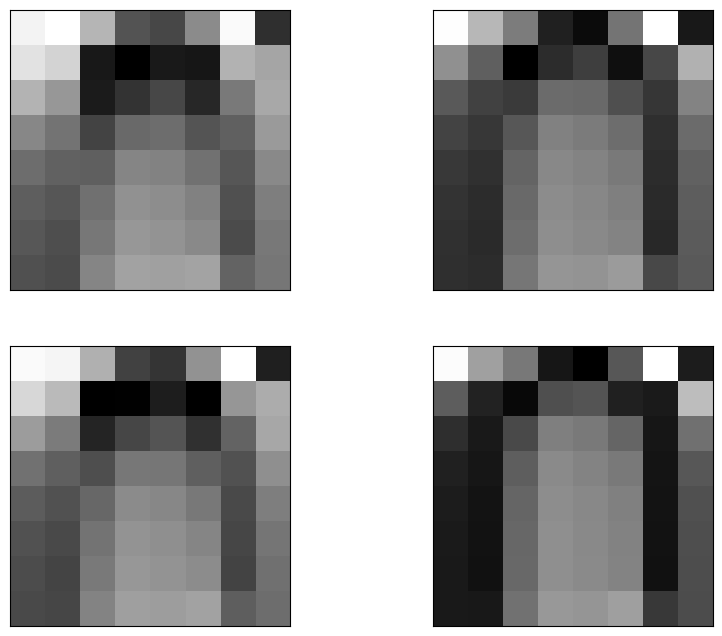

In [70]:
latent_vars0 = encoder0.predict(test_data)

samples = [0, 5, 10, 15]
plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(latent_vars0[samples[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


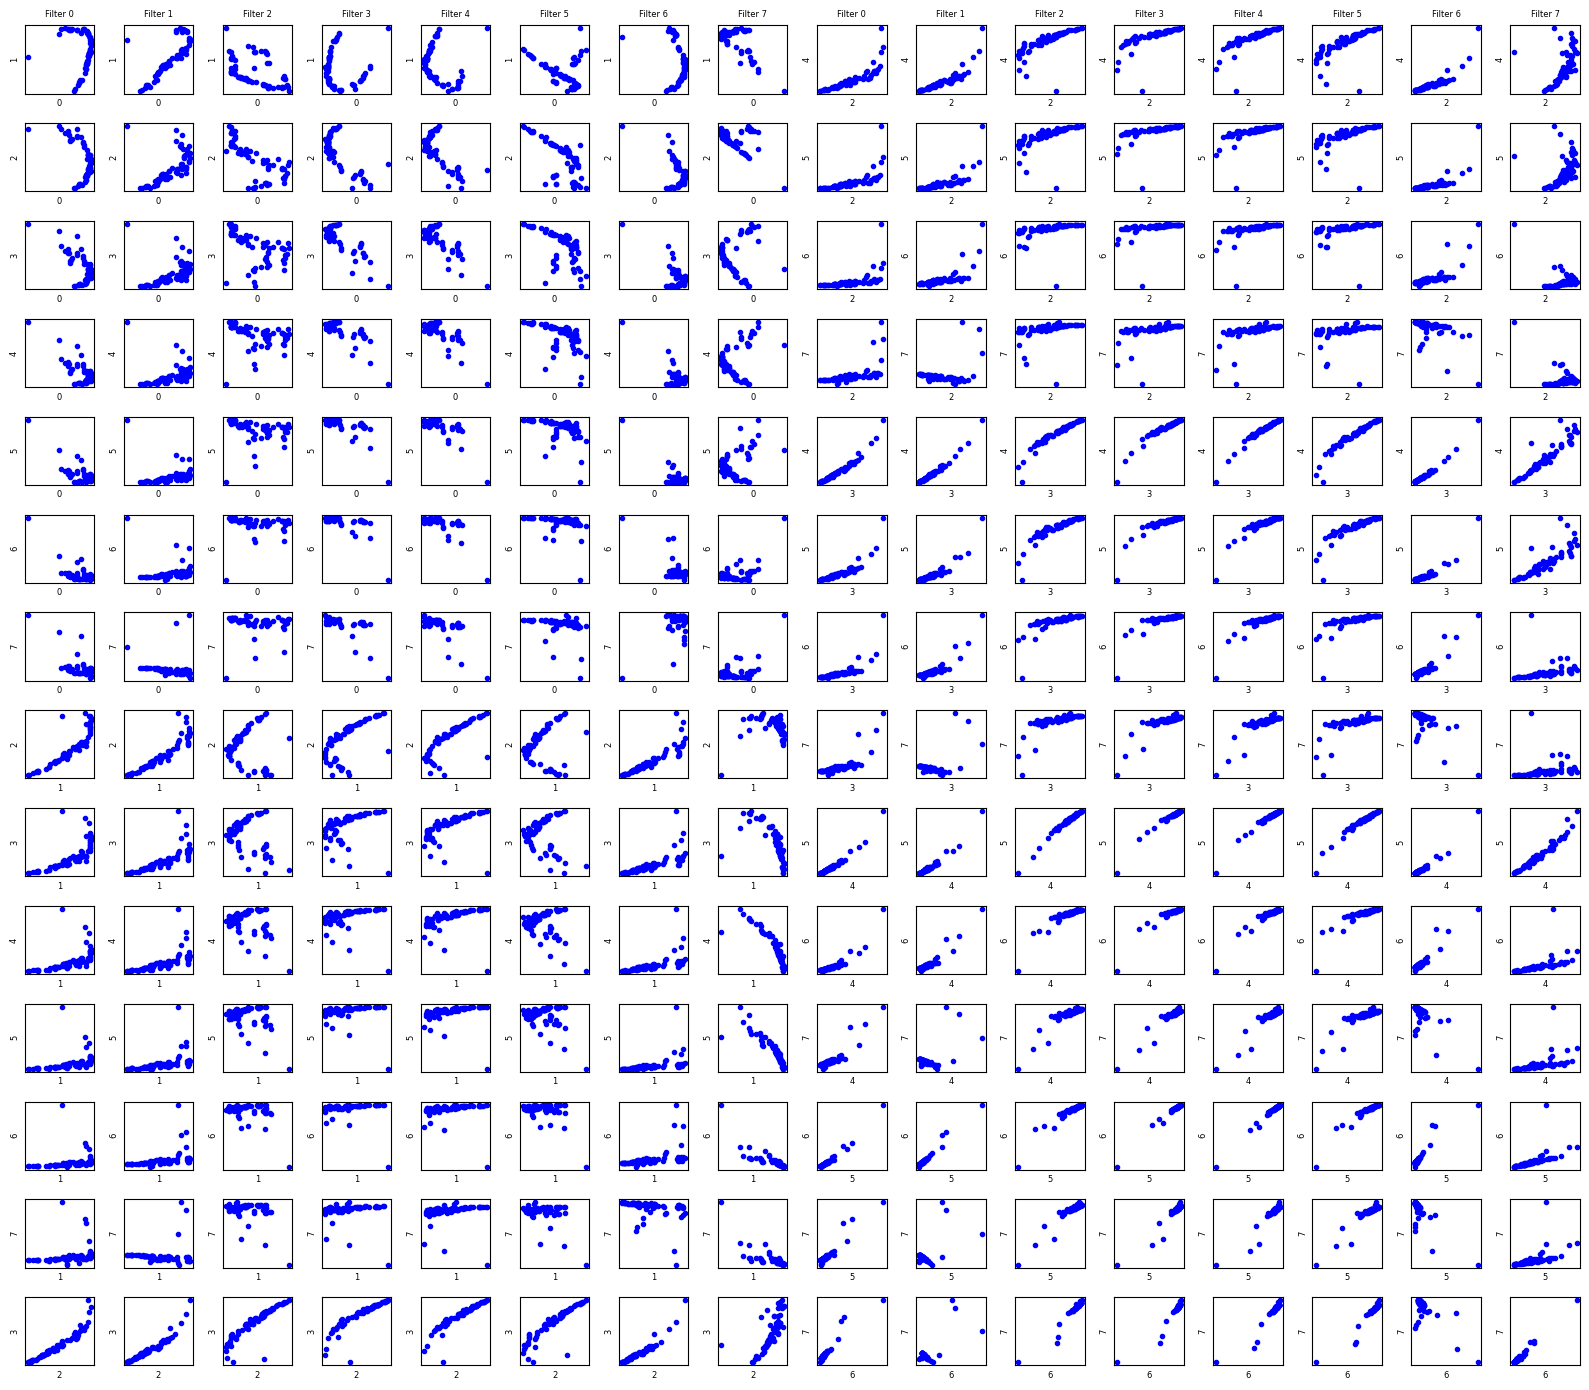

In [ ]:
from itertools import combinations 
codings0 = encoder0.predict(i_data_norm)
fig = plt.figure(figsize=(16, 14))
combos = list(combinations(np.arange(8), 2))
for j in range(28):
    for i in range(8):
        if (j < 14):
            ax = fig.add_subplot(14, 16, j*16 + i+1)
        else:
            ax = fig.add_subplot(14, 16, (j - 14)*16 + i+9)
        ax.plot(codings0[:, combos[j][0], i], codings0[:, combos[j][1], i], "b.")
        ax.set_xlabel(str(combos[j][0]), fontsize=6)
        ax.set_ylabel(str(combos[j][1]), fontsize=6)
        # ax.set_title(f'Filter {i}', fontsize=6)
        if (j == 0 or j == 14):
            ax.set_title(f'Filter {i}', fontsize=6)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)
plt.tight_layout()
# plt.savefig('latent_vars_8x8_big.png', bbox_inches='tight', dpi=200)
plt.show()

In [74]:
# Build encoder using Keras Layers API
num_filters = 4
input = keras.Input(shape=input[0].shape)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
encoded1 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(encoded1)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
decoded1 = keras.layers.Conv1D(filters=1, kernel_size=3, activation="sigmoid", padding="same")(x)

encoder1 = keras.Model(input, encoded1)
decoder1 = keras.Model(encoded1, decoded1)
autoencoder1 = keras.Model(input, decoded1)
autoencoder1.compile(optimizer='adam', loss='mean_squared_error') # default: autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [75]:
# Visualize the model architecture
autoencoder1.summary() # print summary of model architecture

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 32, 4)          │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 16, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 16, 4)          │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 8, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 4, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 2, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 4, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 8, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 8, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 521 (2.04 KB)

 Trainable params: 457 (1.79 KB)

 Non-trainable params: 64 (256.00 B)

In [80]:
# Train the model
autoencoder1.fit(i_data_aug, i_data_aug, epochs=50, batch_size=100, shuffle=True, validation_data=(test_data, test_data))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1418 - val_loss: 0.1646
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0454 - val_loss: 0.1313
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208 - val_loss: 0.1111
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.1011
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0910
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.0762
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0529
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 0.0231
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0099
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


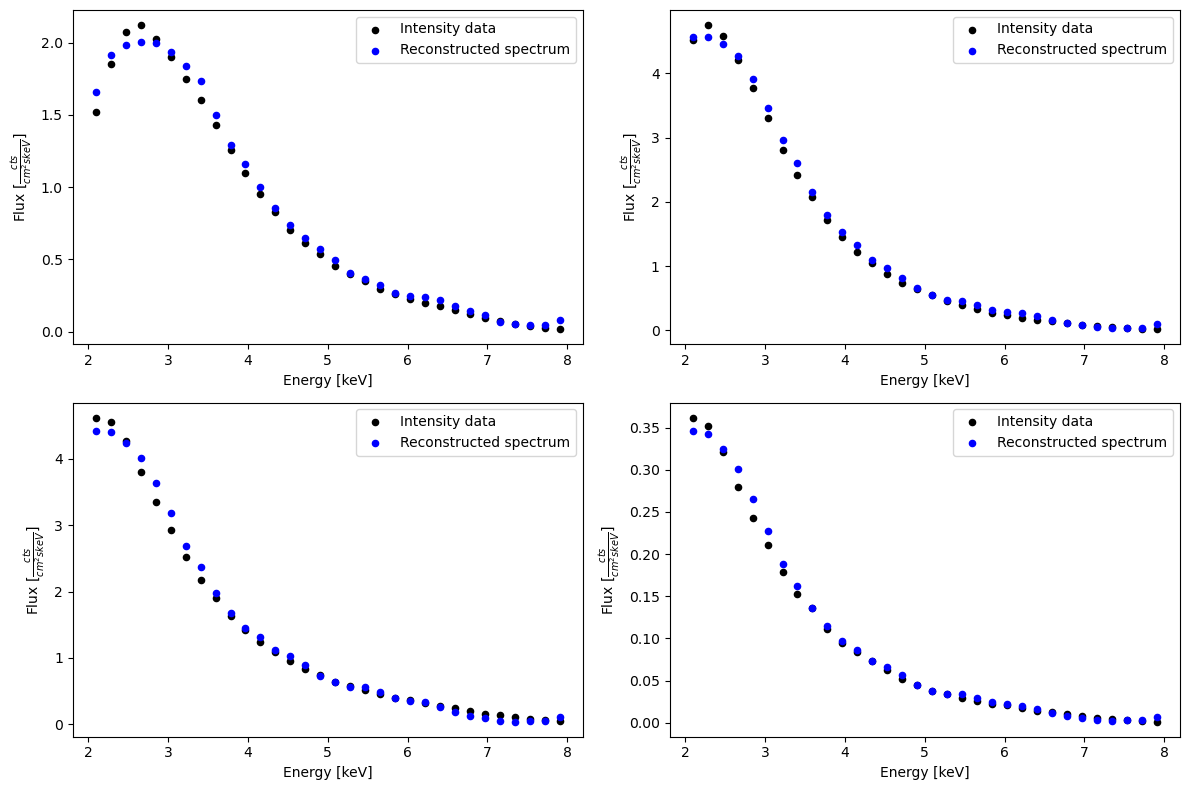

In [ ]:
predictions1 = autoencoder1.predict(test_data)
samples = [0, 4, 14, 19]
plt.figure(figsize=(12, 8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, test_max_vals[samples[i]] * test_data[samples[i]], s=20, c='black', label = 'Intensity data')
    ax.scatter(midpts, test_max_vals[samples[i]] * predictions1[samples[i]], s=20, c='blue', label = 'Reconstructed spectrum')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.tight_layout()
# plt.savefig('reconstruction_2x4.png', bbox_inches='tight', dpi=200)
plt.show()

In [83]:
# Calculate the mean squared error between the input and output
MSE(test_data, predictions1.reshape(test_data.shape))

MSE = 4.10E-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


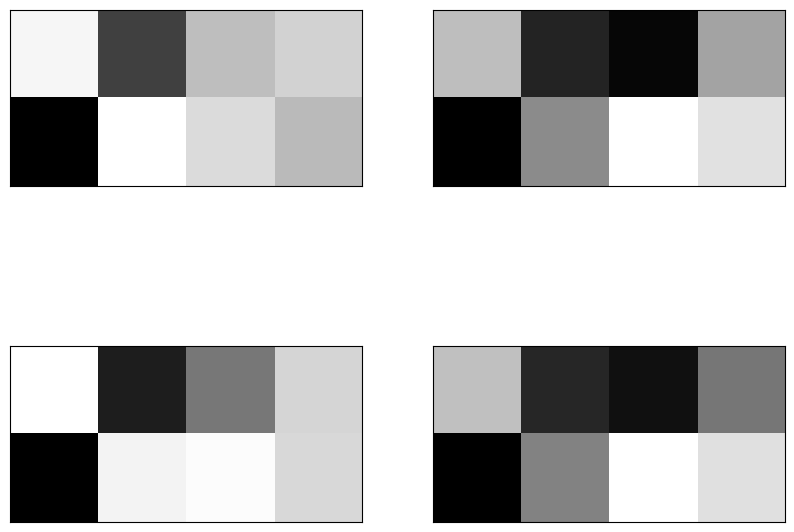

In [84]:
latent_vars1 = encoder1.predict(test_data)

samples = [0, 5, 10, 15]
plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(latent_vars1[samples[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


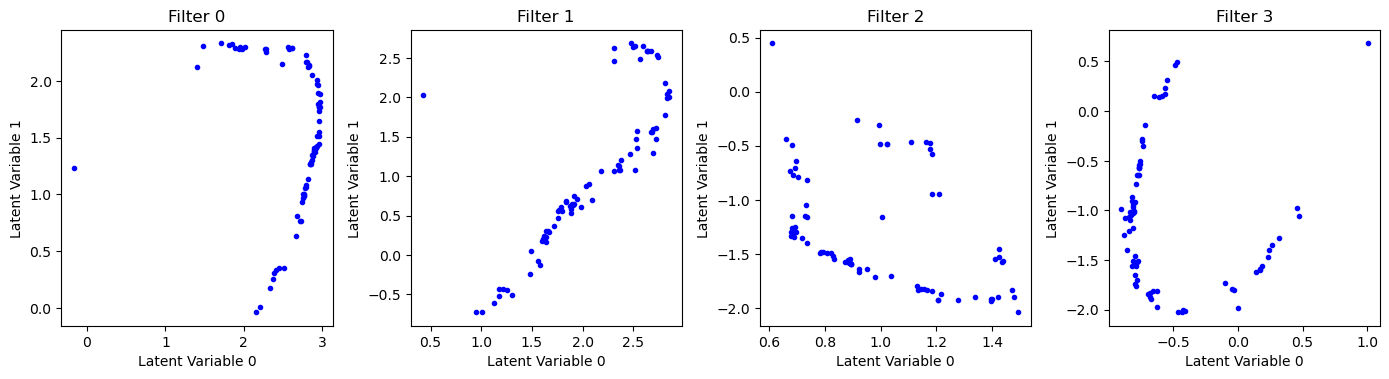

In [ ]:
latent_vars1 = encoder1.predict(i_data_norm)
rng = np.random.default_rng()
fig = plt.figure(figsize=(14, 7))
for i in range(4):
    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(codings0[:, 0, i], codings0[:, 1, i], "b.")
    ax.set_xlabel("Latent Variable 0")
    ax.set_ylabel("Latent Variable 1")
    ax.set_title(f'Filter {i}')
plt.tight_layout()
# plt.savefig('latent_vars_2x4.png', bbox_inches='tight', dpi=200)
plt.show()

In [89]:
# Build encoder using Keras Layers API
num_filters = 4
input = keras.Input(shape=input[0].shape)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
encoded2 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(encoded2)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
decoded2 = keras.layers.Conv1D(filters=1, kernel_size=3, activation="sigmoid", padding="same")(x)

encoder2 = keras.Model(input, encoded2)
decoder2 = keras.Model(encoded2, decoded2)
autoencoder2 = keras.Model(input, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error') # default: autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [91]:
# Visualize the model architecture
autoencoder2.summary() # print summary of model architecture

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 32, 4)          │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 16, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 16, 4)          │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 8, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 8, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 4, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 2, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 1, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 1, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_6 (UpSampling1D)  │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 2, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 657 (2.57 KB)

 Trainable params: 577 (2.25 KB)

 Non-trainable params: 80 (320.00 B)

In [92]:
# Train the model
autoencoder2.fit(i_data_aug, i_data_aug, epochs=50, batch_size=100, shuffle=True, validation_data=(test_data, test_data))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1617 - val_loss: 0.0989
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0836 - val_loss: 0.1009
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 - val_loss: 0.1026
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - val_loss: 0.1031
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.1018
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0968
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0860
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0668
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0453
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0227
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0124
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


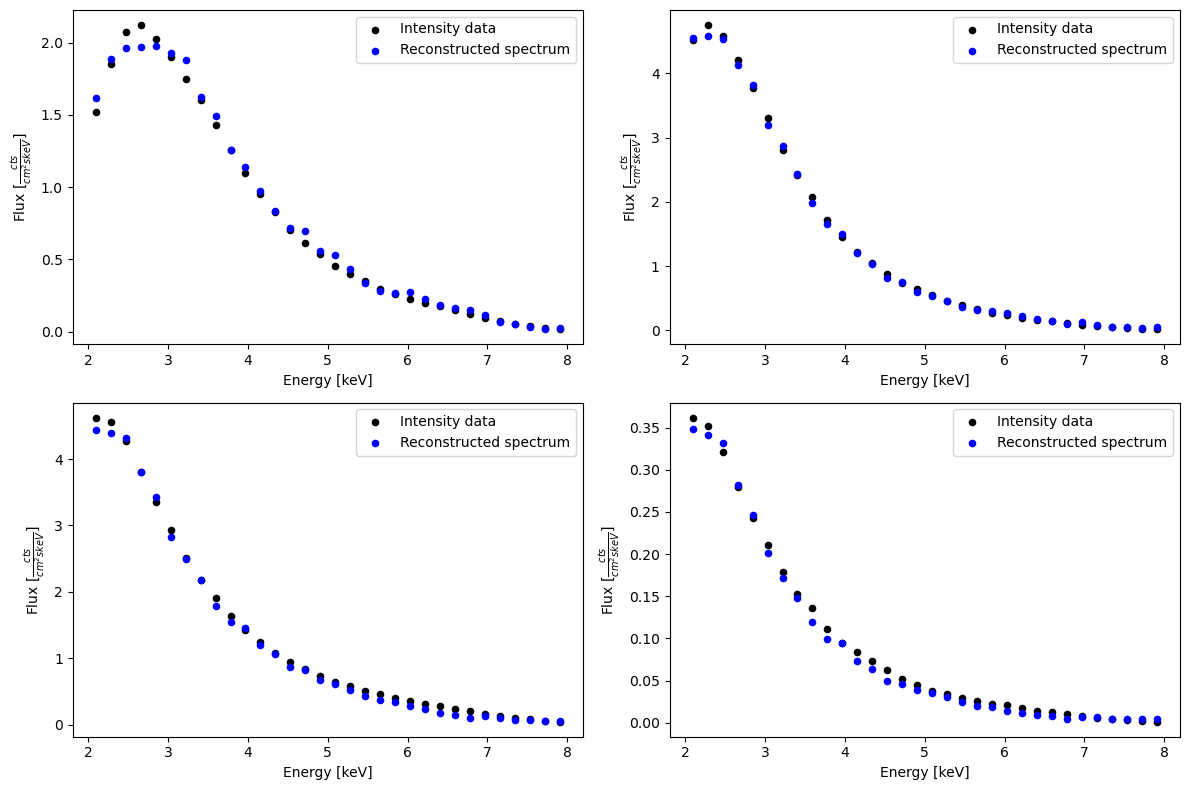

In [ ]:
predictions2 = autoencoder2.predict(test_data)
samples = [0, 4, 14, 19]
plt.figure(figsize=(12, 8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, test_max_vals[samples[i]] * test_data[samples[i]], s=20, c='black', label = 'Intensity data')
    ax.scatter(midpts, test_max_vals[samples[i]] * predictions2[samples[i]], s=20, c='blue', label = 'Reconstructed spectrum')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.tight_layout()
# plt.savefig('reconstruction_1x4.png', bbox_inches='tight', dpi=200)
plt.show()

In [96]:
# Calculate the mean squared error between the input and output
MSE(test_data, predictions2.reshape(test_data.shape))

MSE = 3.70E-04


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


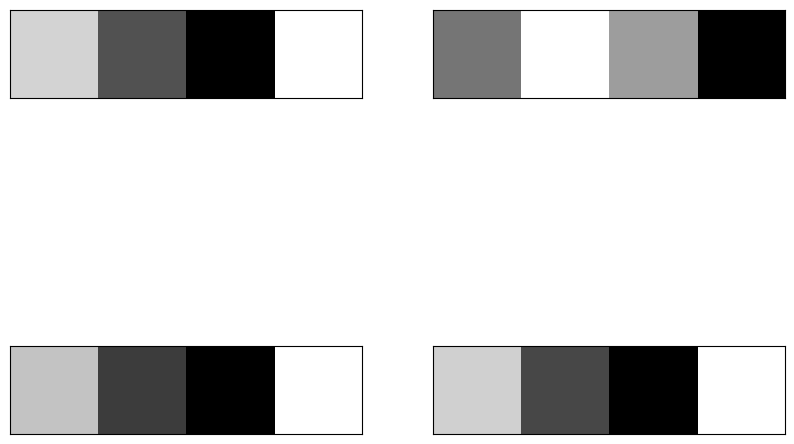

In [97]:
latent_vars2 = encoder2.predict(i_data_norm)
samples = [0, 20, 40, 70]
plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(latent_vars2[samples[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [98]:
# Build encoder using Keras Layers API
num_filters = 2
input = keras.Input(shape=input[0].shape)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
encoded3 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(encoded3)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
decoded3 = keras.layers.Conv1D(filters=1, kernel_size=3, activation="sigmoid", padding="same")(x)

encoder3 = keras.Model(input, encoded3)
decoder3 = keras.Model(encoded3, decoded3)
autoencoder3 = keras.Model(input, decoded3)
autoencoder3.compile(optimizer='adam', loss='mean_squared_error') # default: autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [99]:
# Visualize the model architecture
autoencoder3.summary() # print summary of model architecture

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 32, 2)          │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 2)          │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 16, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 16, 2)          │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 2)          │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 8, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 8, 2)           │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 8, 2)           │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 4, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 4, 2)           │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 4, 2)           │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 2, 2)           │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 2, 2)           │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 1, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 1, 2)           │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 1, 2)           │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_11 (UpSampling1D) │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 2, 2)           │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 2, 2)           │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 221 (884.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 40 (160.00 B)

In [100]:
# Train the model
autoencoder3.fit(i_data_aug, i_data_aug, epochs=50, batch_size=100, shuffle=True, validation_data=(test_data, test_data))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1680 - val_loss: 0.1534
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1144 - val_loss: 0.1346
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0657 - val_loss: 0.1150
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304 - val_loss: 0.0983
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - val_loss: 0.0878
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0779
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - val_loss: 0.0652
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0481
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - val_loss: 0.0310
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0192
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0190
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


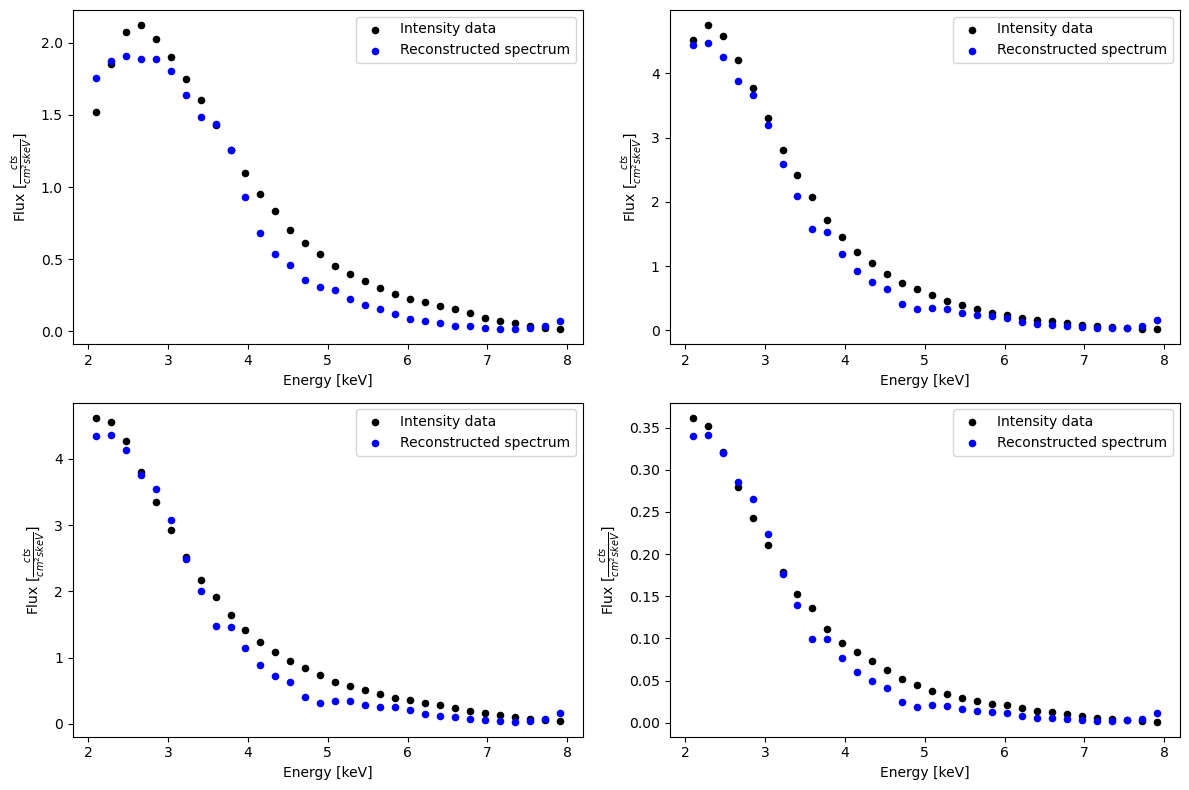

In [ ]:
predictions3 = autoencoder3.predict(test_data)
samples = [0, 4, 14, 19]
plt.figure(figsize=(12, 8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, test_max_vals[samples[i]] * test_data[samples[i]], s=20, c='black', label = 'Intensity data')
    ax.scatter(midpts, test_max_vals[samples[i]] * predictions3[samples[i]], s=20, c='blue', label = 'Reconstructed spectrum')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.tight_layout()
# plt.savefig('reconstruction_1x2.png', bbox_inches='tight', dpi=200)
plt.show()

In [108]:
# Calculate the mean squared error between the input and output
MSE(test_data, predictions3.reshape(test_data.shape))

MSE = 2.61E-03


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


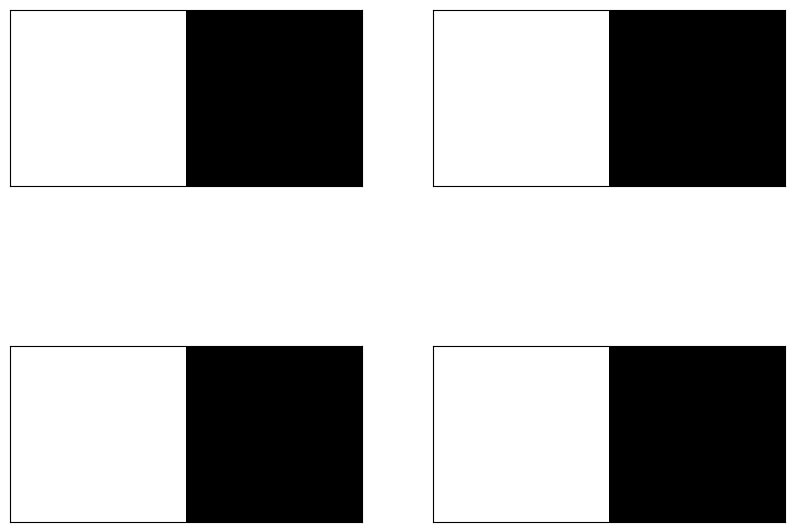

In [103]:
latent_vars3 = encoder3.predict(i_data_norm)
samples = [0, 20, 40, 70]
plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(latent_vars3[samples[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [104]:
# Build encoder using Keras Layers API
num_filters = 4
input = keras.Input(shape=input[0].shape)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=2, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=1, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
encoded4 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)

x = keras.layers.Conv1D(filters=1, kernel_size=3, activation='sigmoid', padding='same')(encoded4)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=2, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
decoded4 = keras.layers.Conv1D(filters=1, kernel_size=3, activation="sigmoid", padding="same")(x)

encoder4 = keras.Model(input, encoded4)
decoder4 = keras.Model(encoded4, decoded4)
autoencoder4 = keras.Model(input, decoded4)
autoencoder4.compile(optimizer='adam', loss='mean_squared_error') # default: autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [105]:
# Visualize the model architecture
autoencoder4.summary() # print summary of model architecture

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 32, 4)          │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 16, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 16, 2)          │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 16, 2)          │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 8, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 8, 1)           │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 8, 1)           │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 4, 1)           │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 4, 1)           │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_16 (UpSampling1D) │ (None, 8, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 8, 2)           │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 8, 2)           │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_17 (UpSampling1D) │ (None, 16, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 16, 4)          │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_18 (UpSampling1D) │ (None, 32, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 32, 1)          │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158 (632.00 B)

 Trainable params: 130 (520.00 B)

 Non-trainable params: 28 (112.00 B)

In [106]:
# Train the model
autoencoder4.fit(i_data_aug, i_data_aug, epochs=50, batch_size=100, shuffle=True, validation_data=(test_data, test_data))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1761 - val_loss: 0.1067
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1110 - val_loss: 0.1019
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0692 - val_loss: 0.0989
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416 - val_loss: 0.0972
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.0946
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152 - val_loss: 0.0898
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - val_loss: 0.0815
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - val_loss: 0.0694
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.0547
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - val_loss: 0.0363
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - val_loss: 0.0216
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


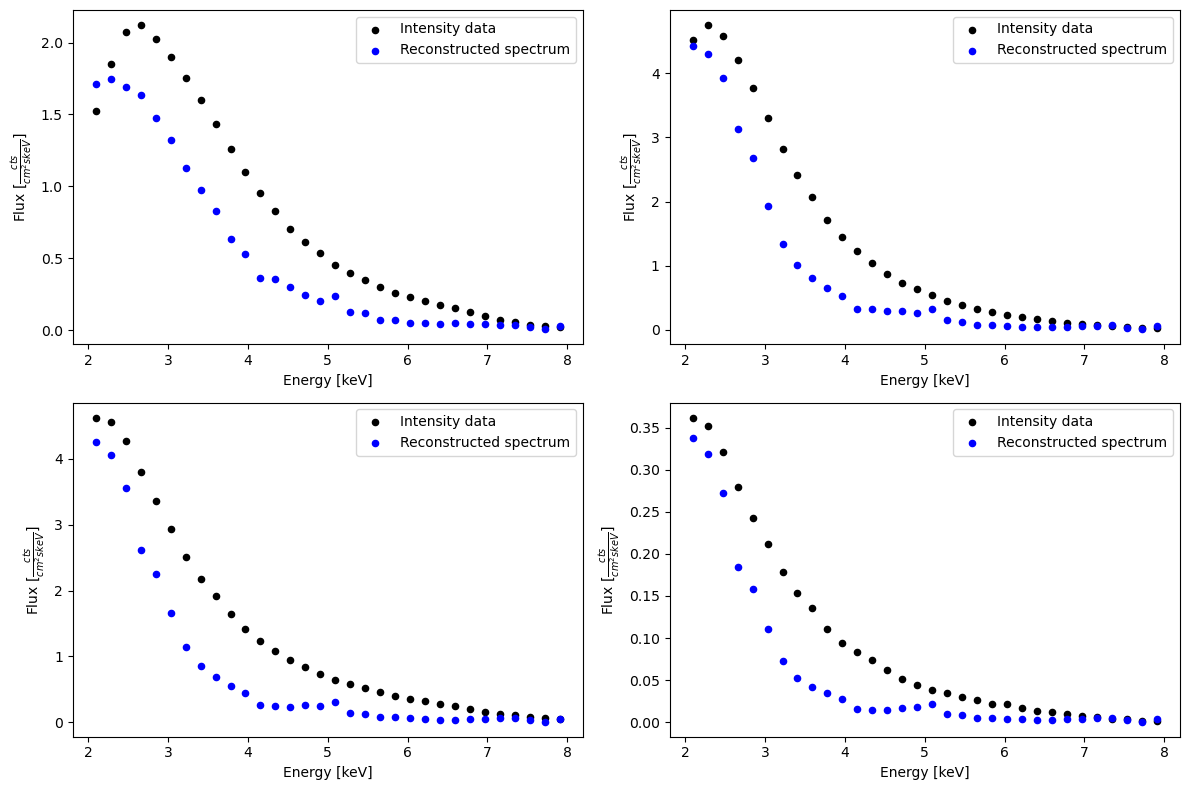

In [107]:
predictions4 = autoencoder4.predict(test_data)
samples = [0, 4, 14, 19]
plt.figure(figsize=(12, 8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, test_max_vals[samples[i]] * test_data[samples[i]], s=20, c='black', label = 'Intensity data')
    ax.scatter(midpts, test_max_vals[samples[i]] * predictions4[samples[i]], s=20, c='blue', label = 'Reconstructed spectrum')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.tight_layout()
# plt.savefig('reconstruction_4x1.png', bbox_inches='tight', dpi=200)
plt.show()

In [109]:
# Calculate the mean squared error between the input and output
MSE(test_data, predictions4.reshape(test_data.shape))

MSE = 2.06E-02


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


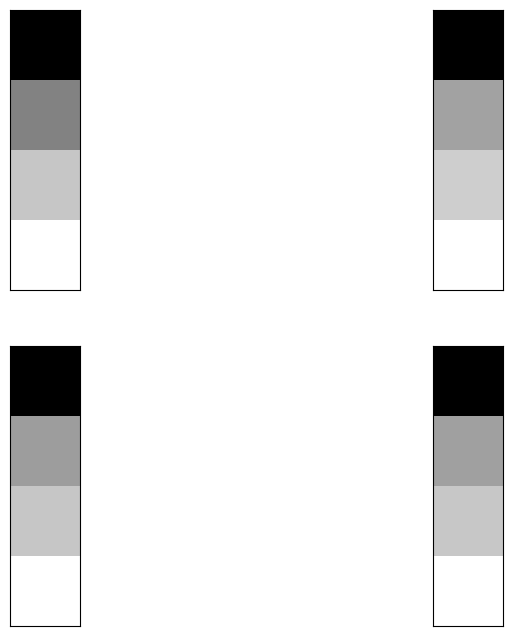

In [111]:
latent_vars4 = encoder4.predict(test_data)
samples = [0, 4, 14, 19]
plt.figure(figsize=(10,8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(latent_vars4[samples[i]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

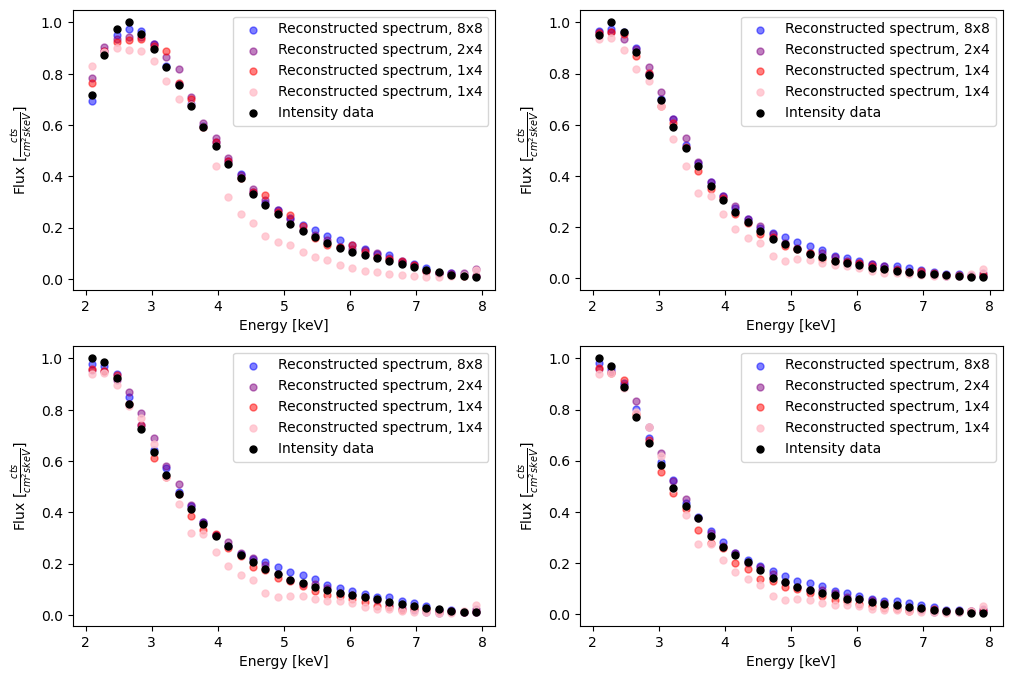

In [112]:
samples = [0, 4, 14, 19]
plt.figure(figsize=(12,8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, max_vals[samples[i]] * predictions0[samples[i]], s=25, c='blue', alpha=0.5, label = 'Reconstructed spectrum, 8x8')
    ax.scatter(midpts, max_vals[samples[i]] * predictions1[samples[i]], s=25, c='purple', alpha=0.5, label = 'Reconstructed spectrum, 2x4')
    ax.scatter(midpts, max_vals[samples[i]] * predictions2[samples[i]], s=25, c='red', alpha=0.5, label = 'Reconstructed spectrum, 1x4')
    ax.scatter(midpts, max_vals[samples[i]] * predictions3[samples[i]], s=25, c='pink', alpha=0.8, label = 'Reconstructed spectrum, 1x4')
    ax.scatter(midpts, max_vals[samples[i]] * test_data[samples[i]], s=25, c='black', label = 'Intensity data')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.show()